In [1]:
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d jsphyg/weather-dataset-rattle-package

100% 3.83M/3.83M [00:01<00:00, 4.37MB/s]
100% 3.83M/3.83M [00:01<00:00, 3.19MB/s]


In [4]:
! unzip /content/weather-dataset-rattle-package.zip

Archive:  /content/weather-dataset-rattle-package.zip
  inflating: weatherAUS.csv          


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm 
import seaborn as sn
from sklearn import metrics, preprocessing, model_selection
import keras_tuner as kt

# Read the Data

In [6]:
dataset = pd.read_csv('/content/weatherAUS.csv')
dataset 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [7]:
# show the dataset information 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Preprocessing the Dataset 

In [8]:
# drop the na values 
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cl

In [9]:
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,2017-06-20,Darwin,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,...,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,No,No
142299,2017-06-21,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,...,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,No
142300,2017-06-22,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,...,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,No
142301,2017-06-23,Darwin,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,...,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,No


array([[<AxesSubplot:title={'center':'MinTemp'}>,
        <AxesSubplot:title={'center':'MaxTemp'}>,
        <AxesSubplot:title={'center':'Rainfall'}>,
        <AxesSubplot:title={'center':'Evaporation'}>],
       [<AxesSubplot:title={'center':'Sunshine'}>,
        <AxesSubplot:title={'center':'WindGustSpeed'}>,
        <AxesSubplot:title={'center':'WindSpeed9am'}>,
        <AxesSubplot:title={'center':'WindSpeed3pm'}>],
       [<AxesSubplot:title={'center':'Humidity9am'}>,
        <AxesSubplot:title={'center':'Humidity3pm'}>,
        <AxesSubplot:title={'center':'Pressure9am'}>,
        <AxesSubplot:title={'center':'Pressure3pm'}>],
       [<AxesSubplot:title={'center':'Cloud9am'}>,
        <AxesSubplot:title={'center':'Cloud3pm'}>,
        <AxesSubplot:title={'center':'Temp9am'}>,
        <AxesSubplot:title={'center':'Temp3pm'}>]], dtype=object)

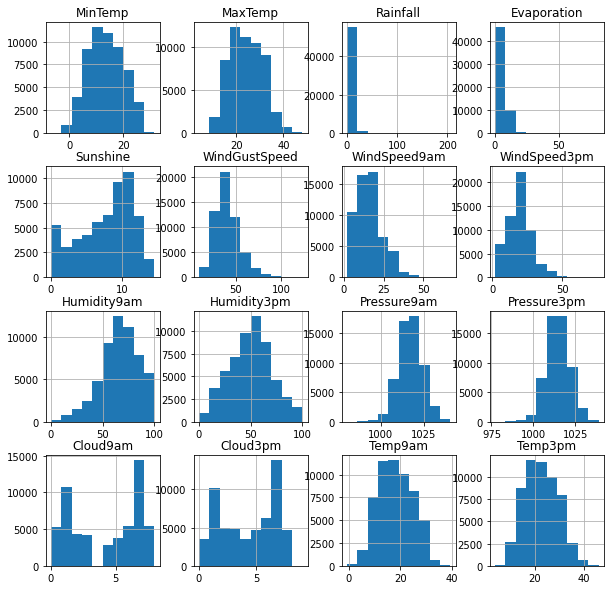

In [10]:
# plot the histogram 
dataset.hist(figsize=(10,10))

In [11]:
dataset.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000


In [12]:
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,2017-06-20,Darwin,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,...,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,No,No
142299,2017-06-21,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,...,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,No
142300,2017-06-22,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,...,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,No
142301,2017-06-23,Darwin,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,...,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,No


In [13]:
# drop out the Date	Location columns 
dataset.drop(columns=['Location','Date'],inplace=True)


In [14]:
dataset 

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,...,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,No,No
142299,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,...,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,No
142300,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,...,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,No
142301,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,...,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,No


In [15]:
dataset .iloc[0]

MinTemp            17.9
MaxTemp            35.2
Rainfall            0.0
Evaporation        12.0
Sunshine           12.3
WindGustDir         SSW
WindGustSpeed      48.0
WindDir9am          ENE
WindDir3pm           SW
WindSpeed9am        6.0
WindSpeed3pm       20.0
Humidity9am        20.0
Humidity3pm        13.0
Pressure9am      1006.3
Pressure3pm      1004.4
Cloud9am            2.0
Cloud3pm            5.0
Temp9am            26.6
Temp3pm            33.4
RainToday            No
RainTomorrow         No
Name: 6049, dtype: object

In [16]:
dataset.WindGustDir=dataset.WindGustDir.factorize()[0]
dataset.WindDir9am=dataset.WindDir9am.factorize()[0]
dataset.WindDir3pm=dataset.WindDir3pm.factorize()[0]
dataset.RainToday=dataset.RainToday.factorize()[0]
dataset.RainTomorrow=dataset.RainTomorrow.factorize()[0]

In [17]:
new_dataset=dataset[dataset.RainToday==1]
new_dataset = new_dataset.append(dataset[dataset.RainToday==0].sample(n=len(new_dataset.RainToday)))
new_dataset

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6068,23.3,39.4,4.8,12.0,10.9,10,59.0,5,10,19.0,...,54.0,14.0,1011.1,1008.5,1.0,7.0,27.0,37.0,1,0
6071,20.3,36.0,18.0,8.2,10.5,11,94.0,2,10,13.0,...,89.0,50.0,1008.6,1006.7,7.0,4.0,24.7,33.4,1,1
6072,22.1,34.7,8.6,8.6,12.4,12,50.0,10,0,11.0,...,46.0,23.0,1008.6,1008.3,2.0,6.0,28.1,33.2,1,0
6083,24.1,41.4,1.6,12.6,12.3,6,39.0,8,3,17.0,...,50.0,21.0,1007.0,1003.5,0.0,4.0,28.2,38.8,1,0
6093,16.1,19.1,26.0,6.6,0.0,13,54.0,13,12,28.0,...,81.0,93.0,1014.3,1013.2,7.0,7.0,17.1,17.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23010,13.6,19.3,0.6,4.0,8.0,14,24.0,13,8,9.0,...,87.0,74.0,1023.4,1021.3,7.0,5.0,16.9,19.1,0,1
89087,19.2,30.1,0.0,6.2,11.1,5,35.0,1,8,17.0,...,65.0,58.0,1014.2,1010.5,1.0,1.0,25.9,29.2,0,0
100048,3.7,17.6,0.2,0.4,9.5,1,22.0,0,14,2.0,...,95.0,76.0,1023.6,1021.4,5.0,2.0,9.4,15.1,0,0
140115,21.3,31.5,0.0,4.4,10.8,4,33.0,7,4,9.0,...,71.0,57.0,1010.9,1007.5,2.0,4.0,26.2,30.6,0,0


In [18]:
# split the data to features and labels 
x=new_dataset.iloc[:,:-2]
y=new_dataset.iloc[:,-2]

In [19]:
# scale the feature values between 0,1
min_max_preprocess =preprocessing.StandardScaler()
min_max_preprocess.fit(x)
x_norm=min_max_preprocess.transform(x)


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>],
       [<AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>],
       [<AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>, <AxesSubplot:>]],
      dtype=object)

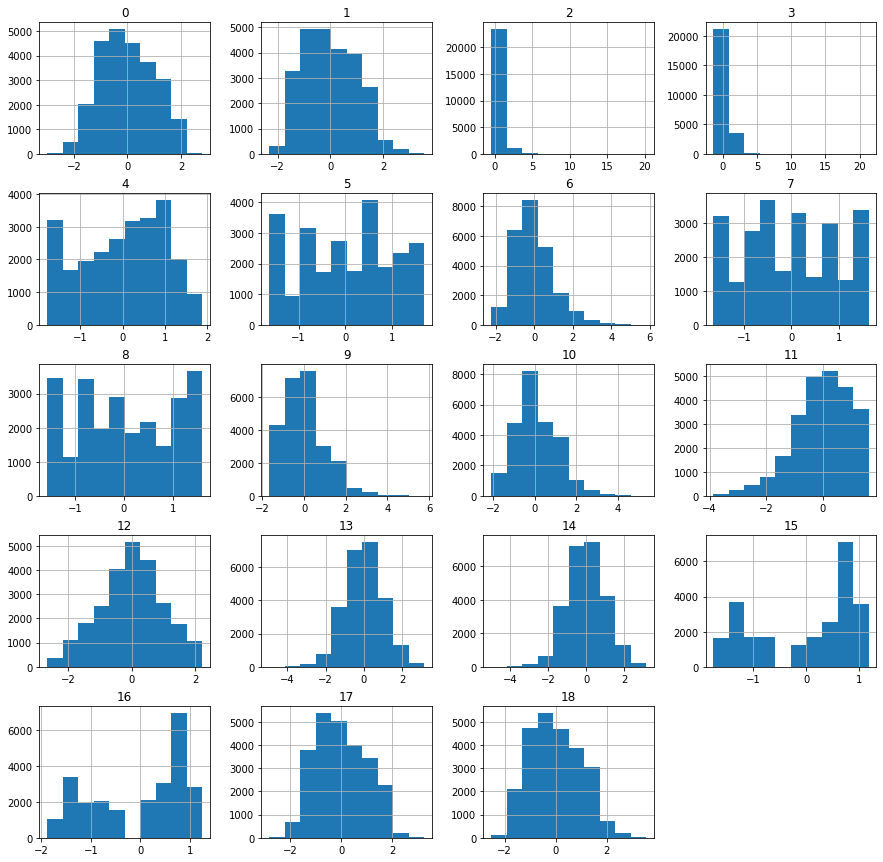

In [20]:
pd.DataFrame(x_norm).hist(figsize=(15,15))

(array([12462.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 12462.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

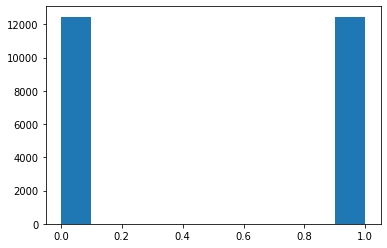

In [21]:
plt.hist(y)

# Spilt the Data to Train & Test 

In [22]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(x_norm,y,test_size=0.1,random_state=42,stratify=y)

# Create the Data Pipeline

In [23]:
# creat the data pipeline
def data_pipeline(x,y,batch_size=32):
    # insert the data to the data pipeline
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(50000)# shuffle the data
    data=data.batch(batch_size)# creat the batch
    data=data.prefetch(tf.data.AUTOTUNE)# run the data processing and training in parallel 
    return data

In [24]:
# create the train pipeline 
train_dataset=data_pipeline(x_train,y_train)
# create the test pipeline
test_dataset=data_pipeline(x_test,y_test)

In [25]:
# get the first batch of data from the train pipeline 
for x,y in train_dataset.take(1):
    print(x)
    print(y)

tf.Tensor(
[[-6.44538077e-01 -4.29309642e-01  5.29134076e-01 -7.15144001e-01
   8.01148430e-01  1.48182954e+00 -5.16263587e-01  3.16485495e-01
  -5.10633345e-01 -6.08583576e-01 -3.47276800e-02  5.16663601e-01
   5.64688489e-02  3.65852576e-01  7.38854479e-01 -1.02409054e+00
   7.44881728e-02 -5.91682001e-01 -3.31085677e-01]
 [ 2.22913179e-03 -8.59337031e-01  7.29893962e-01 -7.71071285e-01
  -4.94919808e-01  1.03724590e+00  4.10959037e-01 -9.90606855e-01
  -9.31570189e-01 -1.35718264e-01 -8.39785994e-01  3.50090482e-01
  -3.86211878e-01 -1.95058271e+00 -7.62839932e-01  1.17698732e+00
   7.44881728e-02 -3.92854698e-01 -6.95373523e-01]
 [ 1.04336659e+00  3.30405413e-01  4.73103510e-02  3.47474393e-01
   1.21589027e+00  1.48078605e-01  8.38907940e-01  7.52182945e-01
   7.52177188e-01  1.40109400e+00  1.23036396e+00  2.94566110e-01
   7.94270060e-01 -1.44314718e-01  1.27053052e-01 -2.90397917e-01
   7.44881728e-02  8.30697931e-01  4.12061528e-01]
 [-3.60591498e-01 -8.45002785e-01  8.1019791

# Model

In [26]:
class Model(tf.keras.Model):
    def __init__(self,units_tuner,activation_tuner,kernel_regularizer_tuner,dropout_tuner):
        super(Model,self).__init__()
        self.dropout_tuner=dropout_tuner
        activation_tuner=[tf.nn.relu,tf.nn.leaky_relu,tf.nn.elu][activation_tuner]


        self.D1=tf.keras.layers.Dense(units_tuner[0],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[0],name='D1')
        self.D1_dropout = tf.keras.layers.Dropout(0.3)
        self.D2=tf.keras.layers.Dense(units_tuner[1],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[1],name='D2')
        self.D2_dropout = tf.keras.layers.Dropout(0.3)
        self.D3=tf.keras.layers.Dense(units_tuner[2],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[2],name='D3')
        self.D3_dropout = tf.keras.layers.Dropout(0.3)
        self.D4=tf.keras.layers.Dense(units_tuner[3],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[3],name='D4')
        self.D4_dropout = tf.keras.layers.Dropout(0.3)
        self.D5=tf.keras.layers.Dense(units_tuner[4],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[4],name='D5')
        self.D5_dropout = tf.keras.layers.Dropout(0.3)
        self.out=tf.keras.layers.Dense(1,activation=tf.nn.sigmoid,name='out')
    def call(self,x ):
        x=self.D1(x)
        if self.dropout_tuner:
            x=self.D1_dropout(x)
        x=self.D2(x)
        if self.dropout_tuner:
            x=self.D2_dropout(x)
        x=self.D3(x)
        if self.dropout_tuner:
            x=self.D3_dropout(x)
        x=self.D4(x)
        if self.dropout_tuner:
            x=self.D4_dropout(x)
        x=self.D5(x)
        if self.dropout_tuner:
            x=self.D5_dropout(x)
        out = self.out(x)
        return out


In [27]:
def model_builder(hp):
    # define the kernel values tuner 
    units_tuner=[hp.Int('D1', min_value=8, max_value=512, step=32),
                  hp.Int('D2', min_value=8, max_value=512, step=32),
                  hp.Int('D3', min_value=8, max_value=512, step=32),
                  hp.Int('D4', min_value=8, max_value=512, step=32),
                  hp.Int('D5', min_value=8, max_value=512, step=32)]
                 
    # define the activation function tuner 
    activation_tuner = hp.Choice('activation',[0,1,2])

    # define the kernel_regularizer_tuner
    kernel_regularizer_tuner=[hp.Choice('regularizer_1',['L1','L2','L1L2']),
                              hp.Choice('regularizer_2',['L1','L2','L1L2']),
                              hp.Choice('regularizer_3',['L1','L2','L1L2']),
                              hp.Choice('regularizer_4',['L1','L2','L1L2']),
                              hp.Choice('regularizer_5',['L1','L2','L1L2']),
                              ]
    # define the dropout_tuner
    dropout_tuner= hp.Choice('dropout',[True,False])
    
    
    model = Model(
                      units_tuner=units_tuner,
                      activation_tuner=activation_tuner,
                      kernel_regularizer_tuner=kernel_regularizer_tuner,
                      dropout_tuner=dropout_tuner,
                     
                      )
    
    model.build((None,19))# build the model 
    
    # define the learning rate tuner 
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # compile the model 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"]
    )
    return model 

In [28]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=10,
                     
                     directory='my_dir',
                     project_name='intro_to_kt')

In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [30]:
tuner.search(train_dataset, epochs=50,validation_data=test_dataset , callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 01m 07s]
val_loss: 0.0716845914721489

Best val_loss So Far: 0.062136970460414886
Total elapsed time: 00h 14m 01s


In [31]:
a=tuner.get_best_hyperparameters()[0]
a.values

{'D1': 40,
 'D2': 136,
 'D3': 168,
 'D4': 200,
 'D5': 72,
 'activation': 0,
 'regularizer_1': 'L2',
 'regularizer_2': 'L1',
 'regularizer_3': 'L2',
 'regularizer_4': 'L1L2',
 'regularizer_5': 'L2',
 'dropout': 0,
 'lr': 0.0014679605301420164}

## Model Evaluation 

In [32]:
#Get optimal hyperparameters and models from the tuner
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 D1 (Dense)                  multiple                  800       
                                                                 
 dropout_5 (Dropout)         multiple                  0 (unused)
                                                                 
 D2 (Dense)                  multiple                  5576      
                                                                 
 dropout_6 (Dropout)         multiple                  0 (unused)
                                                                 
 D3 (Dense)                  multiple                  23016     
                                                                 
 dropout_7 (Dropout)         multiple                  0 (unused)
                                                                 
 D4 (Dense)                  multiple                  3380

In [34]:
model.fit(train_dataset,epochs=50,validation_data=test_dataset)

Epoch 1/50
701/701 [==============================] - 5s 5ms/step - loss: 0.9094 - accuracy: 0.9172 - val_loss: 0.2380 - val_accuracy: 0.9687
Epoch 2/50
701/701 [==============================] - 3s 4ms/step - loss: 0.1867 - accuracy: 0.9798 - val_loss: 0.1755 - val_accuracy: 0.9735
Epoch 3/50
701/701 [==============================] - 4s 5ms/step - loss: 0.1444 - accuracy: 0.9826 - val_loss: 0.1344 - val_accuracy: 0.9840
Epoch 4/50
701/701 [==============================] - 3s 4ms/step - loss: 0.1280 - accuracy: 0.9842 - val_loss: 0.1191 - val_accuracy: 0.9848
Epoch 5/50
701/701 [==============================] - 3s 4ms/step - loss: 0.1137 - accuracy: 0.9867 - val_loss: 0.1018 - val_accuracy: 0.9888
Epoch 6/50
701/701 [==============================] - 4s 5ms/step - loss: 0.1117 - accuracy: 0.9854 - val_loss: 0.2019 - val_accuracy: 0.9559
Epoch 7/50
701/701 [==============================] - 3s 4ms/step - loss: 0.1103 - accuracy: 0.9840 - val_loss: 0.1073 - val_accuracy: 0.9864
Epoch 

<AxesSubplot:>

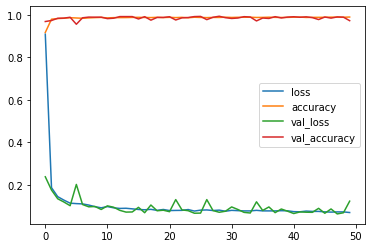

In [35]:
pd.DataFrame(model.history.history).plot()

In [36]:
preds=np.array([])
ys=np.array([])
for x,y in tqdm.tqdm(test_dataset):
    pred = model.predict(x)
    preds=np.append(preds,pred)
  
    ys=np.append(ys,y)
    
    
    
    

  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  1%|▏         | 1/78 [00:00<00:13,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:06, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:05, 13.45it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:04, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:00<00:04, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:00<00:04, 16.26it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:00<00:04, 15.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:01<00:04, 15.74it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:01<00:03, 16.48it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:01<00:03, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:01<00:03, 16.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:01<00:03, 17.47it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:01<00:03, 17.02it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:01<00:02, 17.17it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:01<00:02, 17.23it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:01<00:02, 17.02it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:02<00:02, 17.44it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:02<00:02, 17.39it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:02<00:02, 17.25it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:02<00:02, 17.52it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:02<00:02, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:02<00:02, 17.25it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:02<00:01, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:02<00:01, 16.85it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 49/78 [00:03<00:01, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:03<00:01, 16.60it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:03<00:01, 16.65it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:03<00:01, 16.41it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:03<00:01, 16.65it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 59/78 [00:03<00:01, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:03<00:00, 17.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:03<00:00, 16.62it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:03<00:00, 16.42it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:04<00:00, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:04<00:00, 16.40it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:04<00:00, 16.74it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:04<00:00, 16.00it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:04<00:00, 16.52it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 77/78 [00:04<00:00, 16.48it/s]

1/1 [==============================] - 0s 79ms/step


100%|██████████| 78/78 [00:04<00:00, 16.15it/s]


In [37]:
 preds = preds>0.5
 preds=preds.astype(int)

In [38]:
preds.shape

(2493,)

accuracy_score: 0.972723626153229
precision_score: 0.974135188878937
recall_score: 0.972723626153229
f1_score: 0.9727036164988265


<AxesSubplot:>

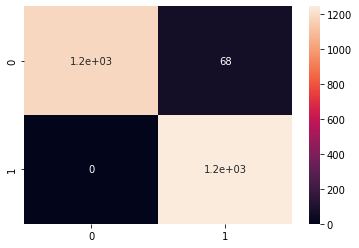

In [39]:
accuracy_score=metrics.accuracy_score(y_true=ys,y_pred=preds)
precision_score=metrics.precision_score(ys,preds,average='weighted')
recall_score=metrics.recall_score(ys,preds,average='weighted')
f1_score=metrics.f1_score(ys,preds,average='weighted')
confion_metrix=metrics.confusion_matrix(ys,preds)
print('accuracy_score:',accuracy_score)
print('precision_score:',precision_score)
print('recall_score:',recall_score)
print('f1_score:',f1_score)
sn.heatmap(confion_metrix,annot=True,)